Image loaded successfully. Shape: (3072, 4080, 3)
Using kernel size: (385, 385)
Enhancement Metrics:
PSNR: 14.8719
SSIM: 0.8867
UCIQE: inf


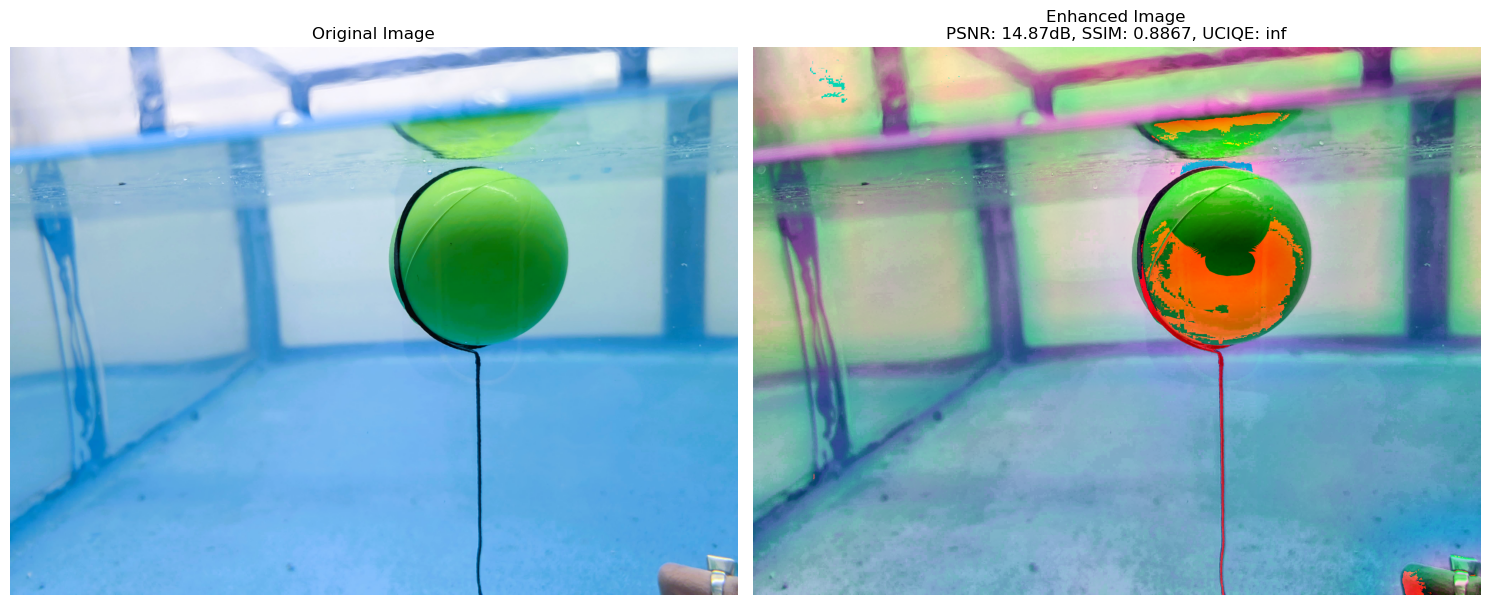

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

def load_image(img_path):
    """Load an image and check if it's valid."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image from {img_path}")
    print(f"Image loaded successfully. Shape: {img.shape}")
    return img

def apply_clahe(img, clip_limit=2.0):
    """Apply CLAHE to enhance contrast in LAB color space."""
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    a_clahe = clahe.apply(a)
    b_clahe = clahe.apply(b)
    
    # Merge channels and convert back to BGR
    lab_clahe = cv2.merge([l_clahe, a_clahe, b_clahe])
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

def decompose_image(img):
    """Decompose image into base and detail layers."""
    # Split into color channels
    b, g, r = cv2.split(img)
    
    # Calculate adaptive kernel size (more reasonable size)
    h, w = r.shape
    kernel_size = max(min(h, w) // 8, 3)
    kernel_size = kernel_size + (1 - kernel_size % 2)  # Ensure odd size
    kernel = (kernel_size, kernel_size)
    
    print(f"Using kernel size: {kernel}")
    
    # Extract base layers
    base_r = cv2.blur(r, kernel)
    base_g = cv2.blur(g, kernel)
    base_b = cv2.blur(b, kernel)
    
    # Extract detail layers
    detail_r = r - base_r
    detail_g = g - base_g
    detail_b = b - base_b
    
    return (b, g, r), (base_r, base_g, base_b), (detail_r, detail_g, detail_b)

def compensate_red_channel(channels, base_layers, detail_layers):
    """Compensate for red channel attenuation in underwater images."""
    b, g, r = channels
    base_r = base_layers[0]
    detail_r, detail_g, detail_b = detail_layers
    
    # Determine which channel to use for compensation
    g_mean = np.mean(g)
    b_mean = np.mean(b)
    
    if g_mean > b_mean:
        detail_comp = detail_g
    else:
        detail_comp = detail_b
    
    # Compensate red channel
    r_comp = base_r + detail_comp
    
    return r_comp

def restore_color_balance(r_comp, g, b, alpha=0.8):
    """Restore color balance using modified Gray World assumption."""
    # Calculate gray mean
    gray_mean = (np.mean(r_comp) + np.mean(g) + np.mean(b)) / 3
    
    # Calculate scaling factors
    k_r = alpha * gray_mean / np.mean(r_comp) if np.mean(r_comp) > 0 else alpha
    k_g = gray_mean / np.mean(g) if np.mean(g) > 0 else 1.0
    k_b = gray_mean / np.mean(b) if np.mean(b) > 0 else 1.0
    
    # Apply color correction
    r_final = np.clip(r_comp * k_r, 0, 255).astype(np.uint8)
    g_final = np.clip(g * k_g, 0, 255).astype(np.uint8)
    b_final = np.clip(b * k_b, 0, 255).astype(np.uint8)
    
    # Merge channels
    return cv2.merge([b_final, g_final, r_final])

def calculate_metrics(enhanced, original):
    """Calculate image quality metrics."""
    # PSNR
    mse = np.mean((enhanced.astype(np.float32) - original.astype(np.float32)) ** 2)
    psnr = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')
    
    # SSIM
    min_dim = min(enhanced.shape[0], enhanced.shape[1])
    win_size = min(7, min_dim - (min_dim % 2) + 1) if min_dim < 7 else 7
    
    try:
        # For newer versions of scikit-image
        ssim = structural_similarity(enhanced, original, 
                                   channel_axis=2,
                                   win_size=win_size)
    except TypeError:
        # For older versions
        ssim = structural_similarity(enhanced, original, 
                                   multichannel=True,
                                   win_size=win_size)
    
    # UCIQE (Underwater Color Image Quality Evaluation)
    # Convert to YCrCb for chroma calculation
    ycrcb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2YCrCb)
    
    # Extract components
    y, cr, cb = cv2.split(ycrcb)
    
    # Calculate chroma
    chroma = np.sqrt((cr - 128)**2 + (cb - 128)**2)
    
    # Calculate contrast of luminance
    con_lum = np.std(y)
    
    # Calculate average saturation
    avg_sat = np.mean(chroma)
    
    # UCIQE coefficients from the paper
    c1, c2, c3 = 0.4680, 0.2745, 0.2576
    
    # Calculate UCIQE
    uciqe = c1 * np.std(chroma) + c2 * con_lum + c3 * avg_sat
    
    return {
        'PSNR': psnr,
        'SSIM': ssim,
        'UCIQE': uciqe
    }

def visualize_results(original, enhanced, metrics=None):
    """Visualize original and enhanced images with metrics."""
    plt.figure(figsize=(15, 10))
    
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    title = 'Enhanced Image'
    if metrics:
        title += f"\nPSNR: {metrics['PSNR']:.2f}dB, SSIM: {metrics['SSIM']:.4f}, UCIQE: {metrics['UCIQE']:.4f}"
    plt.title(title)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def DAC_enhancement(img_path, clip_limit=2.0, alpha=0.8):
    """Main function for Decomposition and Compensation enhancement."""
    # Load image
    original = load_image(img_path)
    
    # Step 1: Contrast Enhancement with CLAHE
    img_clahe = apply_clahe(original, clip_limit)
    
    # Step 2: Image Decomposition
    channels, base_layers, detail_layers = decompose_image(img_clahe)
    
    # Step 3: R-channel Compensation
    r_comp = compensate_red_channel(channels, base_layers, detail_layers)
    
    # Step 4: Color Restoration
    enhanced = restore_color_balance(r_comp, channels[1], channels[0], alpha)
    
    return original, enhanced

def main():
    """Main function to run the enhancement process."""
    img_path = r"C:\Users\shubh\Documents\SOP\GreenBall.jpg"
    
    # Process image
    original, enhanced = DAC_enhancement(img_path)
    
    # Calculate metrics
    metrics = calculate_metrics(enhanced, original)
    print("Enhancement Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Visualize results
    visualize_results(original, enhanced, metrics)
    
    return original, enhanced, metrics

if __name__ == "__main__":
    main()


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

def load_image(img_path):
    """Load an image and check if it's valid."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image from {img_path}")
    print(f"Image loaded successfully. Shape: {img.shape}")
    return img

def apply_clahe(img, clip_limit=2.0):
    """Apply CLAHE to enhance contrast in LAB color space."""
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    a_clahe = clahe.apply(a)
    b_clahe = clahe.apply(b)
    
    # Merge channels and convert back to BGR
    lab_clahe = cv2.merge([l_clahe, a_clahe, b_clahe])
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

def decompose_image(img):
    """Decompose image into base and detail layers."""
    # Split into color channels
    b, g, r = cv2.split(img)
    
    # Calculate adaptive kernel size (more reasonable size)
    h, w = r.shape
    kernel_size = max(min(h, w) // 8, 3)
    kernel_size = kernel_size + (1 - kernel_size % 2)  # Ensure odd size
    kernel = (kernel_size, kernel_size)
    
    print(f"Using kernel size: {kernel}")
    
    # Extract base layers
    base_r = cv2.blur(r, kernel)
    base_g = cv2.blur(g, kernel)
    base_b = cv2.blur(b, kernel)
    
    # Extract detail layers
    detail_r = r - base_r
    detail_g = g - base_g
    detail_b = b - base_b
    
    return (b, g, r), (base_r, base_g, base_b), (detail_r, detail_g, detail_b)

def compensate_red_channel(channels, base_layers, detail_layers):
    """Compensate for red channel attenuation in underwater images."""
    b, g, r = channels
    base_r = base_layers[0]
    detail_r, detail_g, detail_b = detail_layers
    
    # Determine which channel to use for compensation
    g_mean = np.mean(g)
    b_mean = np.mean(b)
    
    if g_mean > b_mean:
        detail_comp = detail_g
    else:
        detail_comp = detail_b
    
    # Compensate red channel
    r_comp = base_r + detail_comp
    
    return r_comp

def restore_color_balance(r_comp, g, b, alpha=0.8):
    """Restore color balance using modified Gray World assumption."""
    # Calculate gray mean
    gray_mean = (np.mean(r_comp) + np.mean(g) + np.mean(b)) / 3
    
    # Calculate scaling factors
    k_r = alpha * gray_mean / np.mean(r_comp) if np.mean(r_comp) > 0 else alpha
    k_g = gray_mean / np.mean(g) if np.mean(g) > 0 else 1.0
    k_b = gray_mean / np.mean(b) if np.mean(b) > 0 else 1.0
    
    # Apply color correction
    r_final = np.clip(r_comp * k_r, 0, 255).astype(np.uint8)
    g_final = np.clip(g * k_g, 0, 255).astype(np.uint8)
    b_final = np.clip(b * k_b, 0, 255).astype(np.uint8)
    
    # Merge channels
    return cv2.merge([b_final, g_final, r_final])

def calculate_metrics(enhanced, original):
    """Calculate image quality metrics."""
    # PSNR
    mse = np.mean((enhanced.astype(np.float32) - original.astype(np.float32)) ** 2)
    psnr = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')
    
    # SSIM
    min_dim = min(enhanced.shape[0], enhanced.shape[1])
    win_size = min(7, min_dim - (min_dim % 2) + 1) if min_dim < 7 else 7
    
    try:
        # For newer versions of scikit-image
        ssim = structural_similarity(enhanced, original, 
                                   channel_axis=2,
                                   win_size=win_size)
    except TypeError:
        # For older versions
        ssim = structural_similarity(enhanced, original, 
                                   multichannel=True,
                                   win_size=win_size)
    
    # UCIQE (Underwater Color Image Quality Evaluation)
    # Convert to YCrCb for chroma calculation
    ycrcb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2YCrCb)
    
    # Extract components
    y, cr, cb = cv2.split(ycrcb)
    
    # Calculate chroma
    chroma = np.sqrt((cr - 128)**2 + (cb - 128)**2)
    
    # Calculate contrast of luminance
    con_lum = np.std(y)
    
    # Calculate average saturation
    avg_sat = np.mean(chroma)
    
    # UCIQE coefficients from the paper
    c1, c2, c3 = 0.4680, 0.2745, 0.2576
    
    # Calculate UCIQE
    uciqe = c1 * np.std(chroma) + c2 * con_lum + c3 * avg_sat
    
    return {
        'PSNR': psnr,
        'SSIM': ssim,
        'UCIQE': uciqe
    }

def visualize_results(original, enhanced, metrics=None):
    """Visualize original and enhanced images with metrics."""
    plt.figure(figsize=(15, 10))
    
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    title = 'Enhanced Image'
    if metrics:
        title += f"\nPSNR: {metrics['PSNR']:.2f}dB, SSIM: {metrics['SSIM']:.4f}, UCIQE: {metrics['UCIQE']:.4f}"
    plt.title(title)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def DAC_enhancement(img_path, clip_limit=2.0, alpha=0.8):
    """Main function for Decomposition and Compensation enhancement."""
    # Load image
    original = load_image(img_path)
    
    # Step 1: Contrast Enhancement with CLAHE
    img_clahe = apply_clahe(original, clip_limit)
    
    # Step 2: Image Decomposition
    channels, base_layers, detail_layers = decompose_image(img_clahe)
    
    # Step 3: R-channel Compensation
    r_comp = compensate_red_channel(channels, base_layers, detail_layers)
    
    # Step 4: Color Restoration
    enhanced = restore_color_balance(r_comp, channels[1], channels[0], alpha)
    
    return original, enhanced

def main():
    """Main function to run the enhancement process."""
    img_path = r"C:\Users\shubh\Documents\SOP\YellowBall.jpg"
    
    # Process image
    original, enhanced = DAC_enhancement(img_path)
    
    # Calculate metrics
    metrics = calculate_metrics(enhanced, original)
    print("Enhancement Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Visualize results
    visualize_results(original, enhanced, metrics)
    
    return original, enhanced, metrics

if __name__ == "__main__":
    main()


Image loaded successfully. Shape: (4080, 3072, 3)
Using kernel size: (385, 385)


C:\Users\shubh\anaconda3\envs\CV_1\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Enhancement Metrics:
PSNR: 19.2164
SSIM: 0.8903
UCIQE: inf


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

def load_image(img_path):
    """Load an image and check if it's valid."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image from {img_path}")
    print(f"Image loaded successfully. Shape: {img.shape}")
    return img

def apply_clahe(img, clip_limit=2.0):
    """Apply CLAHE to enhance contrast in LAB color space."""
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    a_clahe = clahe.apply(a)
    b_clahe = clahe.apply(b)
    
    # Merge channels and convert back to BGR
    lab_clahe = cv2.merge([l_clahe, a_clahe, b_clahe])
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

def decompose_image(img):
    """Decompose image into base and detail layers."""
    # Split into color channels
    b, g, r = cv2.split(img)
    
    # Calculate adaptive kernel size (more reasonable size)
    h, w = r.shape
    kernel_size = max(min(h, w) // 8, 3)
    kernel_size = kernel_size + (1 - kernel_size % 2)  # Ensure odd size
    kernel = (kernel_size, kernel_size)
    
    print(f"Using kernel size: {kernel}")
    
    # Extract base layers
    base_r = cv2.blur(r, kernel)
    base_g = cv2.blur(g, kernel)
    base_b = cv2.blur(b, kernel)
    
    # Extract detail layers
    detail_r = r - base_r
    detail_g = g - base_g
    detail_b = b - base_b
    
    return (b, g, r), (base_r, base_g, base_b), (detail_r, detail_g, detail_b)

def compensate_red_channel(channels, base_layers, detail_layers):
    """Compensate for red channel attenuation in underwater images."""
    b, g, r = channels
    base_r = base_layers[0]
    detail_r, detail_g, detail_b = detail_layers
    
    # Determine which channel to use for compensation
    g_mean = np.mean(g)
    b_mean = np.mean(b)
    
    if g_mean > b_mean:
        detail_comp = detail_g
    else:
        detail_comp = detail_b
    
    # Compensate red channel
    r_comp = base_r + detail_comp
    
    return r_comp

def restore_color_balance(r_comp, g, b, alpha=0.8):
    """Restore color balance using modified Gray World assumption."""
    # Calculate gray mean
    gray_mean = (np.mean(r_comp) + np.mean(g) + np.mean(b)) / 3
    
    # Calculate scaling factors
    k_r = alpha * gray_mean / np.mean(r_comp) if np.mean(r_comp) > 0 else alpha
    k_g = gray_mean / np.mean(g) if np.mean(g) > 0 else 1.0
    k_b = gray_mean / np.mean(b) if np.mean(b) > 0 else 1.0
    
    # Apply color correction
    r_final = np.clip(r_comp * k_r, 0, 255).astype(np.uint8)
    g_final = np.clip(g * k_g, 0, 255).astype(np.uint8)
    b_final = np.clip(b * k_b, 0, 255).astype(np.uint8)
    
    # Merge channels
    return cv2.merge([b_final, g_final, r_final])

def calculate_metrics(enhanced, original):
    """Calculate image quality metrics."""
    # PSNR
    mse = np.mean((enhanced.astype(np.float32) - original.astype(np.float32)) ** 2)
    psnr = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')
    
    # SSIM
    min_dim = min(enhanced.shape[0], enhanced.shape[1])
    win_size = min(7, min_dim - (min_dim % 2) + 1) if min_dim < 7 else 7
    
    try:
        # For newer versions of scikit-image
        ssim = structural_similarity(enhanced, original, 
                                   channel_axis=2,
                                   win_size=win_size)
    except TypeError:
        # For older versions
        ssim = structural_similarity(enhanced, original, 
                                   multichannel=True,
                                   win_size=win_size)
    
    # UCIQE (Underwater Color Image Quality Evaluation)
    # Convert to YCrCb for chroma calculation
    ycrcb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2YCrCb)
    
    # Extract components
    y, cr, cb = cv2.split(ycrcb)
    
    # Calculate chroma
    chroma = np.sqrt((cr - 128)**2 + (cb - 128)**2)
    
    # Calculate contrast of luminance
    con_lum = np.std(y)
    
    # Calculate average saturation
    avg_sat = np.mean(chroma)
    
    # UCIQE coefficients from the paper
    c1, c2, c3 = 0.4680, 0.2745, 0.2576
    
    # Calculate UCIQE
    uciqe = c1 * np.std(chroma) + c2 * con_lum + c3 * avg_sat
    
    return {
        'PSNR': psnr,
        'SSIM': ssim,
        'UCIQE': uciqe
    }

def visualize_results(original, enhanced, metrics=None):
    """Visualize original and enhanced images with metrics."""
    plt.figure(figsize=(15, 10))
    
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    title = 'Enhanced Image'
    if metrics:
        title += f"\nPSNR: {metrics['PSNR']:.2f}dB, SSIM: {metrics['SSIM']:.4f}, UCIQE: {metrics['UCIQE']:.4f}"
    plt.title(title)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def DAC_enhancement(img_path, clip_limit=2.0, alpha=0.8):
    """Main function for Decomposition and Compensation enhancement."""
    # Load image
    original = load_image(img_path)
    
    # Step 1: Contrast Enhancement with CLAHE
    img_clahe = apply_clahe(original, clip_limit)
    
    # Step 2: Image Decomposition
    channels, base_layers, detail_layers = decompose_image(img_clahe)
    
    # Step 3: R-channel Compensation
    r_comp = compensate_red_channel(channels, base_layers, detail_layers)
    
    # Step 4: Color Restoration
    enhanced = restore_color_balance(r_comp, channels[1], channels[0], alpha)
    
    return original, enhanced

def main():
    """Main function to run the enhancement process."""
    img_path = r"C:\Users\shubh\Documents\SOP\RedBall.jpg"
    
    # Process image
    original, enhanced = DAC_enhancement(img_path)
    
    # Calculate metrics
    metrics = calculate_metrics(enhanced, original)
    print("Enhancement Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Visualize results
    visualize_results(original, enhanced, metrics)
    
    return original, enhanced, metrics

if __name__ == "__main__":
    main()


Image loaded successfully. Shape: (3072, 4080, 3)
Using kernel size: (385, 385)
Enhancement Metrics:
PSNR: 21.6932
SSIM: 0.9556
UCIQE: inf
